In [1]:
import sys
sys.path.append('/home/mila/l/leo.gagnon/latent_control')

%load_ext autoreload
%autoreload 2
from tasks.dsm_diffusion import DSMDiffusion
from tasks.direct_post import DirectPosterior
from tasks.metalearn import MetaLearningTask
import torch
import matplotlib.pyplot as plt
from data.diffusion import LatentDiffusionDataset
from torch2jax import j2t, t2j
import jax.numpy as jnp
import jax
from jax.scipy.special import rel_entr
from einops import repeat
from tqdm import tqdm
import random
import torch
import math
import os

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/mila/l/leo.gagnon/late

In [80]:
task = DirectPosterior.load_from_checkpoint(
    "/network/scratch/l/leo.gagnon/latent_control_log/checkpoints/vva2z10q/last.ckpt", strict=False
)
task.cuda();

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['seen_tokens', 'val_latents', 'train_latents']
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['seen_tokens', 'val_latents', 'train_latents']
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['full_data.base_task.seen_tokens', 'full_data.base_task.val_latents', 'full_data.base_task.train_latents', 'train_data.base_task.seen_tokens', 'train_data.base_task.val_latents', 'train_data.base_task.train_latents']
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:195: Found keys that are not in th

In [81]:
task.full_data.cfg.context_length = [10,10]

In [100]:
raw_latent, cond_input_ids, cond_ignore_mask, cond_tokens, latent = task.full_data.__getitems__(torch.randint(0, len(task.full_data), (100,))).values()

/home/mila/l/leo.gagnon/latent_control/data/hmm.py:599: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  intv_envs = jnp.array(intv_envs)


In [101]:
logits = task.forward(cond_input_ids=cond_input_ids, cond_tokens=cond_tokens, cond_mask=torch.logical_not(cond_ignore_mask))

In [102]:
i2l = j2t(task.full_data.base_task.full_data.index_to_latent)

In [103]:
probs = [torch.nn.functional.softmax(l,-1) for l in logits]
probs = [math.prod([probs[i][:,i2l[j,i]] for i in range(len(probs))]) for j in range(len(i2l))]
probs = t2j(torch.stack(probs,-1))

In [109]:
oracle_post = []
for seq in tqdm(cond_input_ids):
    oracle = task.full_data.base_task.full_data.bayesian_oracle(jnp.arange(len(i2l)), jnp.array(seq.tolist()))
    oracle_post += [jnp.exp(oracle['log_alpha_post'][-1])]
oracle_post = jnp.stack(oracle_post)

100%|██████████| 100/100 [00:03<00:00, 25.04it/s]


In [110]:
probs_ = probs + 1e-8
probs_ = probs_ / probs_.sum(-1, keepdims=True)
f_kl = jax.vmap(rel_entr)(oracle_post, probs_).sum(-1)


In [111]:
oracle_post_ = oracle_post + 1e-8
oracle_post_ = oracle_post_ / oracle_post_.sum(-1, keepdims=True)
b_kl = jax.vmap(rel_entr)(probs, oracle_post_).sum(-1)

In [112]:
print(f'ForwardKL : {f_kl.mean()}\nBackwardKL: {b_kl.mean()}')

ForwardKL : 5.687078952789307
BackwardKL: 10.463709831237793


In [113]:
latent_pred = [l.argmax(-1) for l in logits]
latent_pred = torch.stack(latent_pred,-1)

In [116]:
latent_pred[0], raw_latent[0]

(tensor([1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0'),
 tensor([1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0'))

In [117]:
oracle_post[0].max()

Array(0.740162, dtype=float32)

# Run the whole process for N_RUNS

In [107]:
oracle_post[0].max()

Array(0.6673619, dtype=float32)

In [ ]:
N_RUNS = 50

prefix_len = 10
pp_explicit = []
pp_implicit = []


for i in tqdm(range(N_RUNS)):
    seq = task.base_task.full_data[random.randint(0,len(dataset))]['input_ids'][0]
    prefix, suffix = torch.split(seq, [prefix_len, len(seq)-prefix_len], 0)

    z_t = task.diffusion_prior.sample(1024, cond=prefix[None], cond_mask=torch.ones_like(prefix, dtype=bool)[None], cls_free_guidance=1.0)
    if task.diffusion_prior.cfg.normalize_latent:
        z_t = task.diffusion_prior.unnormalize_latent(z_t)

    
    gru_out_full = task.base_task.model.decoder(seq)
    pp_full = t2j(torch.softmax(gru_out_full[:,:50],-1))

    oracle = task.base_task.full_data.bayesian_oracle(jnp.arange(len(dataset)), t2j(seq))
    oracle_pp = oracle['post_pred'][1:]

    next_token_pp = torch.softmax(task.base_task.model.decoder.lm_head(z_t[:,-1])[:,:50],-1)
    next_token_pp = t2j(next_token_pp)

    next_token_kl_cond = rel_entr(oracle_pp[len(prefix)-1], next_token_pp.mean(0)).sum()
    next_token_kl_full = rel_entr(oracle_pp[len(prefix)-1], pp_full[len(prefix)-1]).sum()
    
    pp_explicit.append(next_token_kl_cond)
    pp_implicit.append(next_token_kl_full)

In [ ]:
pp_explicit_ = jnp.stack(pp_explicit)
pp_implicit_ = jnp.stack(pp_implicit)

In [ ]:
pp_explicit_.std(0)

Array(0.4530168, dtype=float32)

In [ ]:
pp_implicit_.std()

Array(0.40835232, dtype=float32)

Text(0, 0.5, 'KL to oracle')

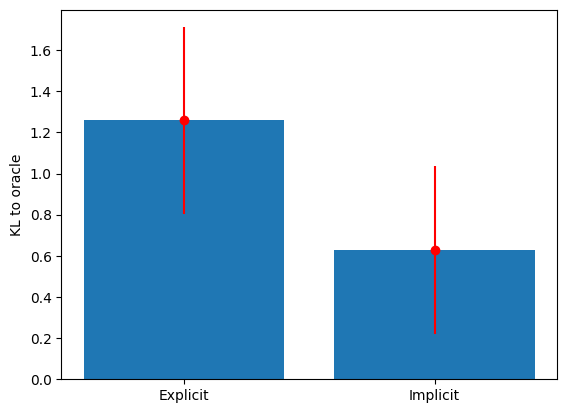

In [ ]:
plt.bar(['Explicit', 'Implicit'], [pp_explicit_.mean(), pp_implicit_.mean()])
plt.errorbar(['Explicit', 'Implicit'], [pp_explicit_.mean(0), pp_implicit_.mean(0)], yerr=[pp_explicit_.std(0), pp_implicit_.std(0)], fmt='o', color='r')
plt.ylabel('KL to oracle')